In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow.keras
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential
import time
%matplotlib inline

dataset = pd.read_csv(r'E:\Datasets-2020.11.6\5.0-Site_31-TDG.csv')

dataset = dataset.rename(columns={
    u'31 TDG - Active Energy Delivered-Received (kWh)': 'AE_Power',
    u'31 TDG - Current Phase Average (A)': 'Current', #电流
    u'31 TDG - Active Power (kW)': 'Power',   #功率
    u'31 TDG - Performance Ratio (%)': 'PR',   #性能比
    u'31 TDG - Wind Speed (m/s)': 'WindSpeed',    #风速
    u'31 TDG - Weather Temperature': 'Temp', #气温
    u'31 TDG - Weather Relative Humidity (%)': 'Humidaty',   #相对湿度
    u'31 TDG - Global Horizontal Radiation': 'GHI',   #全球水平辐照度
    u'31 TDG - Diffuse Horizontal Radiation': 'DHI',  #扩散水平辐射
    u'31 TDG - Wind Direction (Degrees)': 'WD',  #风向
    u'31 TDG - Weather Daily Rainfall (mm)':'RF',#降雨
})

dataset = dataset.drop(['AE_Power','Current','PR','WindSpeed','WD','RF'],axis=1)#删除列,直接是列名

dataset = dataset.dropna(subset=['Power'])# 删除功率为空的数据组

dataset = dataset.fillna(0) # 所有NAN值赋0

dataset = dataset.drop(dataset[dataset.Power < 0].index)
dataset = dataset.drop(dataset[(dataset.Temp > 2000)|(dataset.Temp < 0)].index)
dataset = dataset.drop(dataset[dataset.Humidaty < 0].index)
dataset = dataset.drop(dataset[(dataset.GHI > 2000)|(dataset.GHI < 0)].index)
dataset = dataset.drop(dataset[dataset.DHI < 0].index)

df14 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2014.csv')
df15 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2015.csv')
df16 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2016.csv')
df17 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2017.csv')
df18 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2018.csv')
df19 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2019.csv')

df14['timestamp'] = pd.to_datetime(df14['timestamp'])
df15['timestamp'] = pd.to_datetime(df15['timestamp'])
df16['timestamp'] = pd.to_datetime(df16['timestamp'])
df17['timestamp'] = pd.to_datetime(df17['timestamp'])
df18['timestamp'] = pd.to_datetime(df18['timestamp'])
df19['timestamp'] = pd.to_datetime(df19['timestamp'])
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

df = pd.concat([df14,df15,df16,df17,df18,df19],axis=0) #axis=0表示按行操作
df = df.drop(['Lat','Lon'],axis=1)

dataset_n = pd.merge(dataset,df,how='left',on='timestamp')

dataset_n = dataset_n.dropna(subset=['UV_Index'])
dataset_n = dataset_n.drop(dataset_n[dataset_n.UV_Index < 0].index)

In [78]:
training_set = dataset_n.iloc[213753:518873,1:7].values 
test_set = dataset_n.iloc[575662:576526,1:7].values 

sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled=sc.transform(test_set)


x_train = np.array(training_set_scaled[:,1:5]) 
y_train = np.array(training_set_scaled[:,0:1]) 
x_test = np.array(test_set_scaled[:,1:5])
y_test = np.array(test_set_scaled[:,0:1])

np.random.seed(3)
np.random.shuffle(x_train)
np.random.seed(3)
np.random.shuffle(y_train)
tf.random.set_seed(3)

model = tf.keras.Sequential([
    Dense(5,activation='relu'),
    Dense(5,activation='relu'),
    Dense(5,activation='relu'),
    Dense(1)
])

#自定义metric函数

def MACU(y_true, y_pred):
    return 1-K.mean(abs(y_true-y_pred)/K.mean(y_true))

start = time.process_time()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.2, nesterov=True),loss='mean_squared_error',metrics=[MACU])
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True,decay=0.1),loss='mean_squared_error',metrics=[MACU])
#model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=0.1),loss='mean_squared_error',metrics=[MACU])
#model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=0.1),loss='mean_squared_error',metrics=[MACU])
#model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1, rho=0.9, momentum=0.2, epsilon=1e-07, centered=True,decay=0.1),loss='mean_squared_error',metrics=[MACU])
#model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1, initial_accumulator_value=0.2, epsilon=1e-07),loss='mean_squared_error',metrics=[MACU])

Train on 228840 samples, validate on 76280 samples
Epoch 1/20
228840/228840 [==============================] - 3s 13us/sample - loss: 0.0080 - MACU: 0.7706 - val_loss: 0.0045 - val_MACU: 0.8464
Epoch 2/20
228840/228840 [==============================] - 2s 10us/sample - loss: 0.0043 - MACU: 0.8439 - val_loss: 0.0045 - val_MACU: 0.8452
Epoch 3/20
228840/228840 [==============================] - 2s 8us/sample - loss: 0.0042 - MACU: 0.8463 - val_loss: 0.0044 - val_MACU: 0.8416
Epoch 4/20
228840/228840 [==============================] - 2s 10us/sample - loss: 0.0041 - MACU: 0.8477 - val_loss: 0.0042 - val_MACU: 0.8515
Epoch 5/20
228840/228840 [==============================] - 2s 9us/sample - loss: 0.0040 - MACU: 0.8490 - val_loss: 0.0042 - val_MACU: 0.8525
Epoch 6/20
228840/228840 [==============================] - 3s 11us/sample - loss: 0.0040 - MACU: 0.8509 - val_loss: 0.0042 - val_MACU: 0.8486
Epoch 7/20
228840/228840 [==============================] - 3s 14us/sample - loss: 0.0040 - M

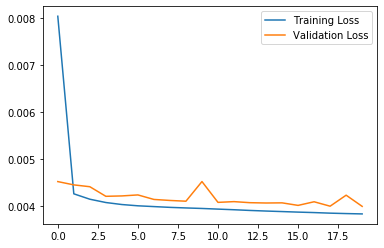

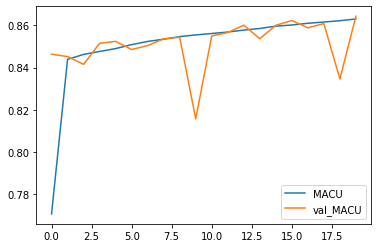

In [79]:
history=model.fit(x_train,y_train,batch_size=200,epochs=20,verbose=1,validation_split=0.25,shuffle=True, validation_freq=1) 
#训练集中用于训练和验证的比例=8：2
end = time.process_time()

print('Training Duration: ',end - start)

model.summary()

loss=history.history['loss']
val_loss=history.history['val_loss']
Metric=history.history['MACU']
val_Metric=history.history['val_MACU']

plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.show()

plt.plot(Metric,label='MACU')
plt.plot(val_Metric,label='val_MACU')
plt.legend()
plt.show()

p_y_test_sc = model.predict(x_test)
test_set_p = test_set
test_set_p = np.array(test_set_p)
test_set_p[:,0:1] = p_y_test_sc
p_y_test = sc.inverse_transform(test_set_p)

percent: 84.41%
均方误差: 0.070612
均方根误差: 0.265729
平均绝对误差: 0.173717


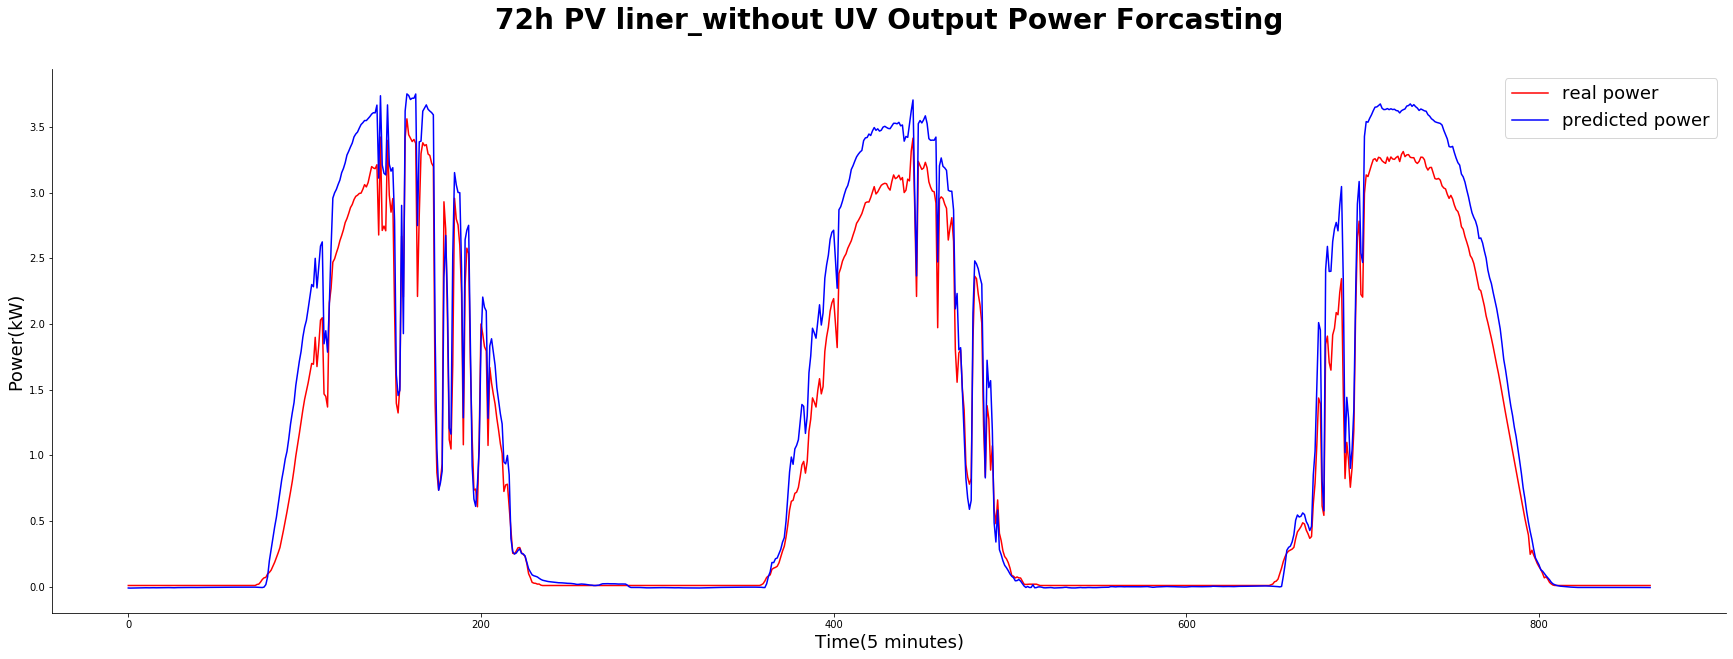

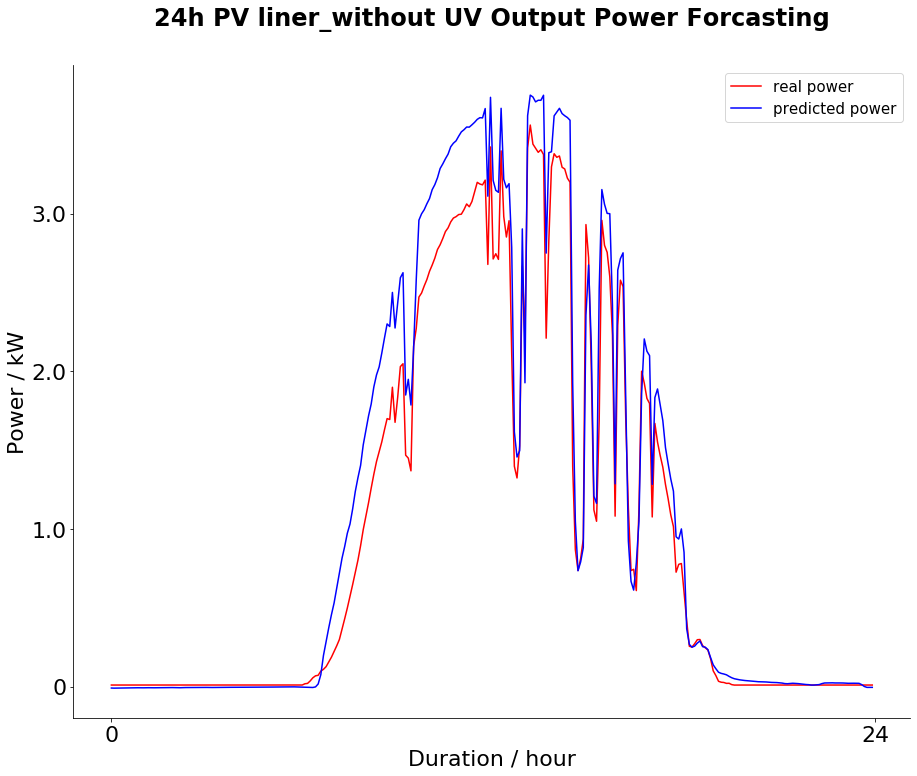

In [80]:
p_y_test_sc = model.predict(x_test)
test_set_p = test_set
test_set_p = np.array(test_set_p)
test_set_p[:,0:1] = p_y_test_sc
p_y_test = sc.inverse_transform(test_set_p)

print('percent: {:.2%}'.format(1-(p_y_test[:,0:1].sum()-test_set[:,0:1].sum())/test_set[:,0:1].sum()))

import math
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(p_y_test[:,0:1],test_set[:,0:1])
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(p_y_test[:,0:1],test_set[:,0:1]))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(p_y_test[:,0:1],test_set[:,0:1])
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)


plt.figure(figsize=(30,10))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(test_set[0:864,0:1],color='red',label='real power')
plt.plot(p_y_test[0:864,0:1],color='blue',label='predicted power')
plt.title('72h PV liner_without UV Output Power Forcasting',fontsize=28,fontweight='heavy', pad=40)
plt.xlabel('Time(5 minutes)',fontsize=18)
plt.ylabel('Power(kW)',fontsize=18)
plt.legend(fontsize=18)
plt.show()


plt.figure(figsize=(15,12))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 288, 576, 864])
ax.set_xticklabels(['0', '24', '48', '72'],fontsize=22)
ax.set_xlabel('Duration / hour',fontsize=22)
ax.set_yticks([0, 1.0, 2.0, 3.0,4.0])
ax.set_yticklabels(['0', '1.0', '2.0', '3.0','4.0'],fontsize=22)
ax.set_ylabel('Power / kW',fontsize=22)
plt.plot(test_set[0:288,0:1],color='red',label='real power')
plt.plot(p_y_test[0:288,0:1],color='blue',label='predicted power')
plt.title('24h PV liner_without UV Output Power Forcasting',fontsize=24,fontweight='heavy', pad=40)
#plt.xlabel('Time(5 minutes)',fontsize=18)
#plt.ylabel('Power(kW)',fontsize=18)
plt.legend(fontsize=15)
plt.show()

# 手动写-2022.1.1

In [555]:
#数据导入

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow.keras
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential
import time
%matplotlib inline

dataset = pd.read_csv(r'E:\Datasets-2020.11.6\5.0-Site_31-TDG.csv')

dataset = dataset.rename(columns={
    u'31 TDG - Active Energy Delivered-Received (kWh)': 'AE_Power',
    u'31 TDG - Current Phase Average (A)': 'Current', #电流
    u'31 TDG - Active Power (kW)': 'Power',   #功率
    u'31 TDG - Performance Ratio (%)': 'PR',   #性能比
    u'31 TDG - Wind Speed (m/s)': 'WindSpeed',    #风速
    u'31 TDG - Weather Temperature': 'Temp', #气温
    u'31 TDG - Weather Relative Humidity (%)': 'Humidaty',   #相对湿度
    u'31 TDG - Global Horizontal Radiation': 'GHI',   #全球水平辐照度
    u'31 TDG - Diffuse Horizontal Radiation': 'DHI',  #扩散水平辐射
    u'31 TDG - Wind Direction (Degrees)': 'WD',  #风向
    u'31 TDG - Weather Daily Rainfall (mm)':'RF',#降雨
})

dataset = dataset.drop(['AE_Power','Current','PR','WindSpeed','WD','RF'],axis=1)#删除列,直接是列名

dataset = dataset.dropna(subset=['Power'])# 删除功率为空的数据组

dataset = dataset.fillna(0) # 所有NAN值赋0

dataset = dataset.drop(dataset[dataset.Power < 0].index)
dataset = dataset.drop(dataset[(dataset.Temp > 2000)|(dataset.Temp < 0)].index)
dataset = dataset.drop(dataset[dataset.Humidaty < 0].index)
dataset = dataset.drop(dataset[(dataset.GHI > 2000)|(dataset.GHI < 0)].index)
dataset = dataset.drop(dataset[dataset.DHI < 0].index)

df14 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2014.csv')
df15 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2015.csv')
df16 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2016.csv')
df17 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2017.csv')
df18 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2018.csv')
df19 = pd.read_csv(r'E:\Datasets-2020.11.6\uv-alice-springs-2019.csv')

df14['timestamp'] = pd.to_datetime(df14['timestamp'])
df15['timestamp'] = pd.to_datetime(df15['timestamp'])
df16['timestamp'] = pd.to_datetime(df16['timestamp'])
df17['timestamp'] = pd.to_datetime(df17['timestamp'])
df18['timestamp'] = pd.to_datetime(df18['timestamp'])
df19['timestamp'] = pd.to_datetime(df19['timestamp'])
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

df = pd.concat([df14,df15,df16,df17,df18,df19],axis=0) #axis=0表示按行操作
df = df.drop(['Lat','Lon'],axis=1)

dataset_n = pd.merge(dataset,df,how='left',on='timestamp')

dataset_n = dataset_n.dropna(subset=['UV_Index'])
dataset_n = dataset_n.drop(dataset_n[dataset_n.UV_Index < 0].index)

In [556]:

minibatch=288


x_train=[]
y_train=[]
x_valid=[]
y_valid=[]
x_test=[]
y_test=[]

training_set = dataset_n.iloc[0:518688,1:7] #1441x288 # 360x288 415008:518688
test_set = dataset_n.iloc[568750:576526,1:7] # 27x288

sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled=sc.transform(test_set)

In [557]:
np.random.seed(6)
np.random.shuffle(x_train)
np.random.seed(6)
np.random.shuffle(y_train)
tf.random.set_seed(6)

x_train = tf.cast(training_set_scaled[0:415008,1:6], tf.float32)
y_train = tf.cast(training_set_scaled[0:415008,0:1], tf.float32)
x_valid = tf.cast(training_set_scaled[415008:518689,1:6], tf.float32)
y_valid = tf.cast(training_set_scaled[415008:518689,0:1], tf.float32)
x_test = tf.cast(test_set_scaled[:,1:6], tf.float32)
y_test = tf.cast(test_set_scaled[:,0:1], tf.float32)

In [558]:
# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(minibatch)
valid_db = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(minibatch)

In [559]:
No_layer = 3 #参数3
layer_0_N=5 #输入层神经元个数，含UV选6，不含UV选5
layer_1_N=5 #隐层1层，神经元6
layer_2_N=5 #隐层1层，神经元6
layer_3_N=1 #隐层1层，神经元6

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）

w1 = tf.Variable(tf.random.normal([layer_0_N, layer_1_N],mean=0, stddev=1))
b1 = tf.Variable(tf.random.normal([layer_1_N],mean=1, stddev=1))
w2 = tf.Variable(tf.random.normal([layer_1_N, layer_2_N], mean=0, stddev=1))
b2 = tf.Variable(tf.random.normal([layer_2_N], mean=1, stddev=1))
w3 = tf.Variable(tf.random.normal([layer_2_N, layer_3_N],mean=0, stddev=1))
b3 = tf.Variable(tf.random.normal([layer_3_N], mean=1, stddev=1))

In [560]:
lr =  0.1 # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 10  # 循环50轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和
loss_all_v = 0

In [561]:
# 训练部分
now_time = time.time()  ##2##
for epoch in range(epoch):  # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            h1 = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            a1 = tf.nn.relu(h1)  # 第一层激活函数
            h2 = tf.matmul(a1,w2) + b2 # 第二层运算
            a2 = tf.nn.relu(h2) #第二层激活函数
            h3 = tf.matmul(a2,w3) + b3 #第三层运算
            a3 = h3 # 第三层激活函数
            loss = tf.reduce_mean(tf.square(y_train-a3))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1,w2,w3,b1,b2,b3])

        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(lr * grads[0])  # 参数w1自更新
        w2.assign_sub(lr * grads[1])  # 参数w2自更新
        w3.assign_sub(lr * grads[2])  # 参数w3自更新
        b1.assign_sub(lr * grads[3])  # 参数b1自更新
        b2.assign_sub(lr * grads[4])  # 参数b2自更新
        b3.assign_sub(lr * grads[5])  # 参数b3自更新
    
        h1_v = tf.matmul(x_valid, w1) + b1
        a1_v = tf.nn.relu(h1_v)
        h2_v = tf.matmul(a1_v, w2) + b2
        a2_v = tf.nn.relu(h2_v)
        h3_v = tf.matmul(a2_v, w3) + b3
        a3_v = h3_v
        loss_v = tf.reduce_mean(tf.square(y_valid-a3_v))

    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {},loss_valid:{}".format(epoch, loss_all / (len(x_train)/minibatch), loss_v))
    train_loss_results.append(loss_all / (len(x_train)/minibatch))  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备
print(' train_loss_results=', train_loss_results)

Epoch 0, loss: 705.6010622208705,loss_valid:0.05920572578907013
Epoch 1, loss: 14.289631722844206,loss_valid:0.027562594041228294
Epoch 2, loss: 8.722067977359984,loss_valid:0.017713259905576706
Epoch 3, loss: 6.666014209957211,loss_valid:0.013102692551910877
Epoch 4, loss: 5.546367734961677,loss_valid:0.011205798014998436
Epoch 5, loss: 4.894434815665591,loss_valid:0.01018540933728218
Epoch 6, loss: 4.484133078389277,loss_valid:0.009385481476783752
Epoch 7, loss: 4.216649219277315,loss_valid:0.00875447504222393
Epoch 8, loss: 4.03718683088664,loss_valid:0.008358914405107498
Epoch 9, loss: 3.915231458595372,loss_valid:0.008098599500954151
 train_loss_results= [705.6010622208705, 14.289631722844206, 8.722067977359984, 6.666014209957211, 5.546367734961677, 4.894434815665591, 4.484133078389277, 4.216649219277315, 4.03718683088664, 3.915231458595372]


In [566]:
pred_sum=[]

p1 = tf.matmul(x_test, w1) + b1
q1 = tf.nn.relu(p1)
p2 = tf.matmul(q1, w2) + b2
q2 = tf.nn.relu(p2)
p3 = tf.matmul(q2, w3) + b3
q3 = p3

test_set_p = test_set_scaled
test_set_p = np.array(test_set_p)
test_set_p[:,0:1] = q3
p_y_test = sc.inverse_transform(test_set_p)
pred=p_y_test[:,0:1]



In [567]:
pred

array([[0.22866432],
       [0.23183954],
       [0.23133121],
       ...,
       [0.04127281],
       [0.04358218],
       [0.04334504]])

In [563]:
np.array(day_pre)-np.array(day_test)

array([151.95599574, 154.45202518, 165.84791916, 169.96404338,
       178.6143817 , 161.96687713, 153.87756131, 159.68609622,
       129.76427182, 142.98900561, 153.68405571, 163.28189143,
       156.48665017, 151.33124452, 166.27146081, 150.03968084,
       165.31891283, 162.28080073, 165.91563323, 169.24602199,
       185.53224507, 173.61797022, 166.51911325, 160.03390921,
       164.34651104, 150.62188382, 148.46358651])

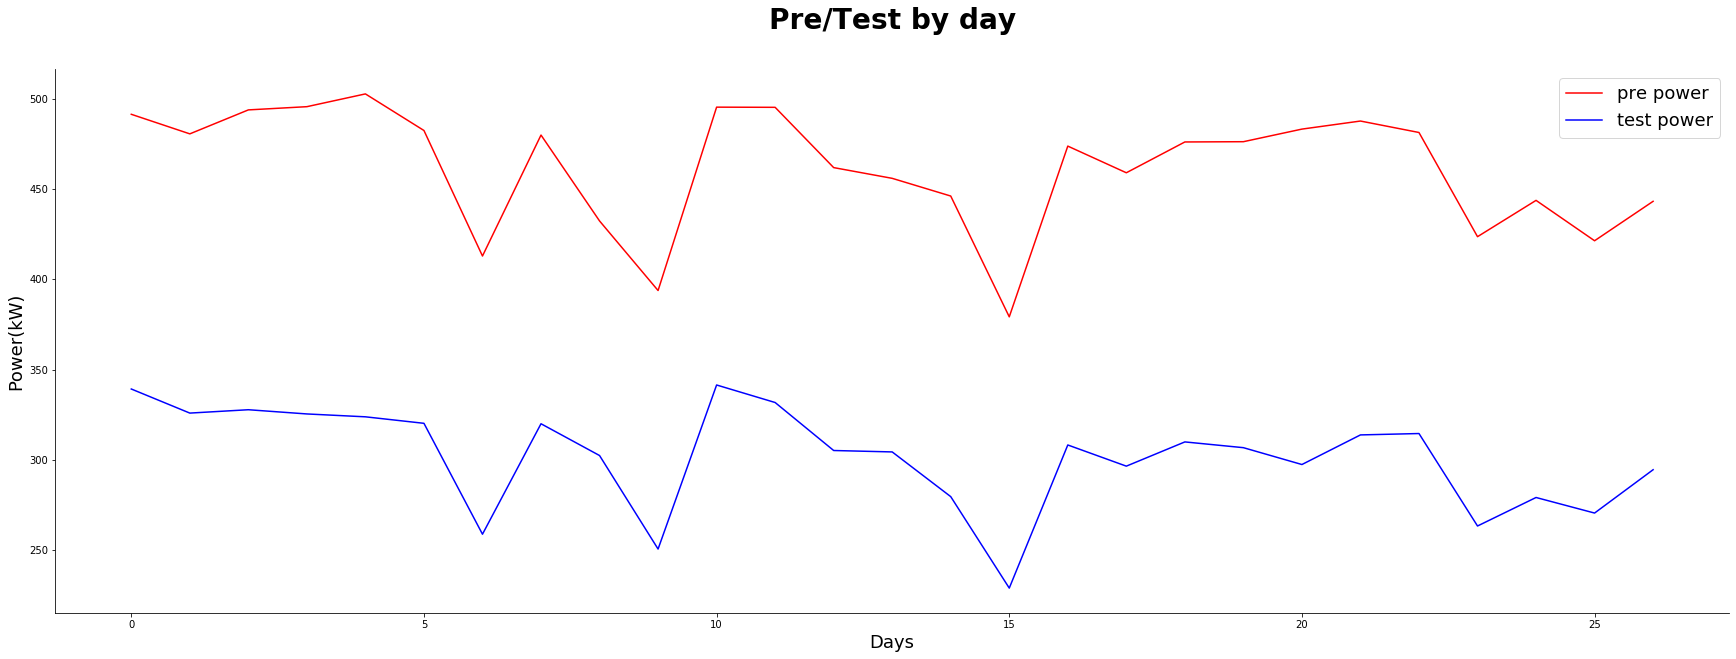

In [564]:
plt.figure(figsize=(30,10))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(day_pre,color='red',label='pre power')
plt.plot(np.array(day_test),color='blue',label='test power')
plt.title('Pre/Test by day',fontsize=28,fontweight='heavy', pad=40)
plt.xlabel('Days',fontsize=18)
plt.ylabel('Power(kW)',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [ ]:
    
print("pred_sum:", np.array(pred_sum)/np.array(test_set)[:,0:1])
print("--------------------------")
total_time = time.time() - now_time  ##3##
print("total_time", total_time)  ##4##

In [275]:
b3

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.356085], dtype=float32)>